In [36]:
from bs4 import BeautifulSoup
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import random as random

In [67]:
class Sudoku:
    def __init__(self):
        self.current_state = np.zeros([9,9], dtype="int")
        self.solution = np.zeros([9,9], dtype="int")
        self.starting_state = np.zeros([9,9], dtype="int")
        self.candidates = candidate_space = np.ones([9,9,9], dtype="int")
        self.checkpoints = {"candidates": [None]*100, "current_state": [None]*100, "prev_candidate": [None]*100}
        
    def set_state(self, board):
        if type(np.arange(3)) is np.ndarray:
            pass
        else:
            board = np.array(board)
        if board.shape != (9,9):
            board = np.reshape(board, [9,9])
            
        self.starting_state = board.copy()
        self.current_state = board.copy()
            
    def __update_candidates(self, board_state, candidate_space):
        for i in range(9):
            for j in range(9):
                square = board_state[i,j]
                
                # check if square is already fixed
                if square != 0:
                    # remove other candidates for square
                    candidate_space[:,i,j] = np.zeros(9, dtype="int")
                    # remove same candidates from row
                    candidate_space[square-1,i,:] = np.zeros(9, dtype="int") 
                    # remove same candidates from column
                    candidate_space[square-1,:,j] = np.zeros(9, dtype="int")
                    # remove same candidates from 3x3 block
                    candidate_space[square-1, int(i/3)*3:int(i/3)*3+3,int(j/3)*3:int(j/3)*3+3] = np.zeros([3,3], dtype="int")
                    
                    candidate_space[square-1,i,j] = 1
        
        return candidate_space
    
    def __update_state(self, state, candidates):
        for i in range(9):
            for j in range(9):
                if state[i,j] == 0 and sum(candidates[:,i,j]) == 1:
                    state[i,j] = list(candidates[:,i,j]).index(1)+1
                    
        return state
                    
    def download_new(self):
        with urllib.request.urlopen("https://nine.websudoku.com") as f:
            html_doc = f.read()
        
        soup = BeautifulSoup(html_doc, 'html.parser')
        
        for element in soup.body.table.form.find_all("input"):
            if 'input id="cheat" name="cheat"' in str(element):
                target = element["value"]
            if 'input id="editmask" type="hidden"' in str(element):
                mask = element["value"]

        for i in range(len(mask)):
            self.solution[int(i/9),i%9] = int(target[i])
            if int(mask[i]) == 0:
                self.starting_state[int(i/9),i%9] = int(target[i])
            else:
                self.starting_state[int(i/9),i%9] = 0
                
        self.current_state = self.starting_state.copy()
        
    def __fill_blanks(self):
        previous_state = np.zeros([9,9], dtype="int")
        success = "stalling" # no more change in candidate space --> "stall"
        while not (previous_state == self.current_state).all():
            previous_state = self.current_state.copy()
            self.candidates = self.__update_candidates(self.current_state, self.candidates)
            self.current_state = self.__update_state(self.current_state, self.candidates)

        if (np.sum(self.candidates, axis=0) == 0).any():
            success = "failure"
        if self.current_state.all() != 0:
            success = "successful"
        return success
            
        
    def solve(self):
        failure_depth = 0
        prev_candidate = 0
        k = 0
        for i in range(10):    
            success = self.__fill_blanks()
            print("status after itteration "+ str(k) + " =", success)
            k += 1
            if success == "successful":
                print("a solution was found!")
                break
            else:
                if success == "stalling":
                    failure_depth += 1
                    # 1. create new checkpoint
                    print("creating new checkpoint at position " + str(failure_depth-1))
                    self.checkpoints["candidates"][failure_depth-1] = self.candidates.copy()
                    self.checkpoints["current_state"][failure_depth-1] = self.current_state.copy()
                    self.checkpoints["prev_candidate"][failure_depth-1] = prev_candidate
                    n_prev_candidates =  0
                    candidate = 0
                    
                    # 1. go to previous checkpoint
                if success == "failure":
                    if len(self.checkpoints["current_state"]) > 0:
                        print("resetting to checkpoint  at position " + str(failure_depth-1))
                        self.current_state = self.checkpoints["current_state"][failure_depth-1]
                        self.candidates = self.checkpoints["candidates"][failure_depth-1]
                        prev_candidate = self.checkpoints["prev_candidate"][failure_depth-1]
#                         failure_depth -= 1 # works but always creates a new checkpoint instead of overwriting an old one at the same depth
                    else:
                        print("unsolvable")
                        break

                # 2. find squares with least candidates in order
                n_candidates = np.sum(self.candidates, axis=0)
                open_candidates = np.unique(n_candidates)[1:]
                candidates_loc = np.vstack(np.where(n_candidates == min(open_candidates)))

                # 3. take next square with least candidates
                loc_min = (candidates_loc[0,0], candidates_loc[1,0])
                
                # 4. set square to first candidate
                candidate = list(self.candidates[:,loc_min[0],loc_min[1]]).index(1,candidate)+1
                print("trying out " + str(candidate) + " from " + str(list(np.arange(1,10)[self.candidates[:,loc_min[0],loc_min[1]] == 1])) + " at " + str((loc_min[0],loc_min[1])))
                self.current_state[loc_min] = candidate

                # 5. go back to loop and solve ...

                # 6. --> success, great!
                # if success break outer while loop
                # 6. --> fail, go back to checkpoint, try next candidate
        
                # 7. ... one of the candidates works --> sucess, great!
                # 7. --> none of the candidates works --> unsolvable
                if candidates_loc.shape[1] == n_prev_candidates:
                    print("unsolvable")
                    break

            
        

In [68]:
S = np.array([6,0,0,3,0,0,9,0,5,0,0,9,0,7,6,2,0,0,0,2,0,4,0,0,0,0,0,7,0,6,0,0,0,0,0,8,9,0,0,0,0,0,0,0,2,2,0,0,0,0,0,1,0,3,0,0,0,0,0,3,0,1,0,0,0,7,6,4,0,5,0,0,5,0,4,0,0,2,0,0,6])
S_solved = np.reshape(np.array([int(char) for char in "678321945459876231321459867716235498943187652285964173862593714137648529594712386"]), [9,9])
sudoku = Sudoku()
# sudoku.download_new()
sudoku.set_state(S)
sudoku.solution = S_solved

In [39]:
sudoku.solve()
# print(sudoku.starting_state)
# print(sudoku.candidates)
# print(sum(sum(sudoku.current_state == 0)))
print(sudoku.current_state)
# print(sudoku.solution)

status after itteration 0 = stalling
creating new checkpoint at position 0
trying out 1 from [1, 8] at (0, 2)
status after itteration 1 = failure
resetting to checkpoint  at position 0
trying out 8 from [1, 8] at (0, 2)
status after itteration 2 = stalling
creating new checkpoint at position 1
trying out 3 from [3, 4] at (1, 0)
status after itteration 3 = failure
resetting to checkpoint  at position 1
trying out 4 from [3, 4] at (1, 0)
status after itteration 4 = stalling
creating new checkpoint at position 2
trying out 3 from [3, 5] at (1, 1)
status after itteration 5 = failure
resetting to checkpoint  at position 2
trying out 5 from [3, 5] at (1, 1)
status after itteration 6 = stalling
creating new checkpoint at position 3
trying out 1 from [1, 3] at (2, 0)
status after itteration 7 = failure
resetting to checkpoint  at position 3
trying out 3 from [1, 3] at (2, 0)
status after itteration 8 = successful
a solution was found!
[[6 7 8 3 2 1 9 4 5]
 [4 5 9 8 7 6 2 3 1]
 [3 2 1 4 5 9 8 6

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
# replace zeros by empty cell
x_train[y_train[:] == 0] = np.zeros([28,28])
x_test[y_test[:] == 0] = np.zeros([28,28])
# normalizing data
x_train = x_train/255
x_test = x_test/255

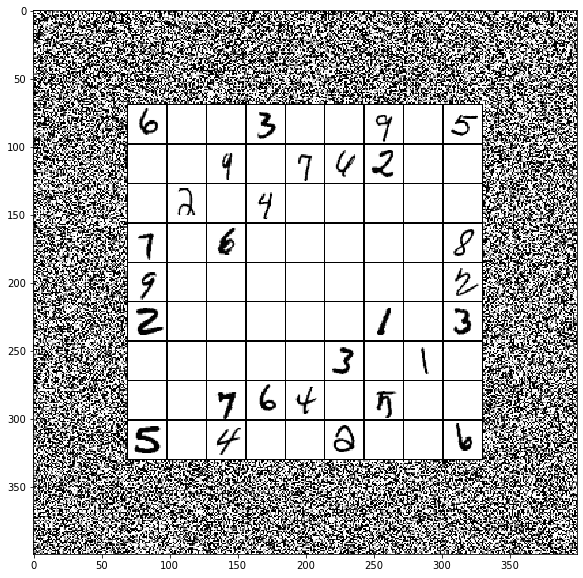

In [163]:
canvas_size = 400
scale = 29
background_size = scale*9+1
board_position = (0, 0) # relative to the center
canvas_noise_params = (0.5, 1.0)
square_noise_params = (0.0, 0.0)

canvas = np.random.normal(canvas_noise_params[0], canvas_noise_params[1], [canvas_size,canvas_size])
canvas[canvas < 0] = 0
canvas[canvas > 1] = 1
background = np.zeros([background_size, background_size])
grid = np.zeros(background.shape)
squares = np.zeros(background.shape)
square_len = int((background_size+8)/9)

for i in range(9):
    for j in range(9):
        grid[square_len*(i)-1*i:square_len*(i+1)-1*i,square_len*(j)-1*j:square_len*(j+1)-1*j] = np.pad(np.zeros([square_len-2*pts,square_len-2*pts]),pts, mode="constant", constant_values=1)
        number = sudoku.current_state[i,j]
        square_content = x_train[y_train[:] == number][random.randint(0,len(x_train[y_train[:] == number]))]
        noise = np.random.normal(square_noise_params[0], square_noise_params[1], square_content[square_content == 0].shape[0])
        noise[noise < 0] = 0
        noise[noise > 1] = 1
        square_content[square_content == 0] = square_content[square_content == 0] + noise
        squares[square_len*(i)-1*i:square_len*(i+1)-1*i, square_len*(j)-1*j:square_len*(j+1)-1*j] = np.pad(square_content, pts, mode="constant", constant_values=0)
board = background + grid + squares

center = int(canvas_size/2)*np.ones(2, dtype = "int")-int(background_size/2)*np.ones(2, dtype = "int")
centered_position = center + board_position
canvas[centered_position[0]:centered_position[0] + board.shape[0], centered_position[1]:centered_position[1] + board.shape[1]] = board
plt.figure(figsize=(10,10))
plt.imshow(canvas, cmap = "Greys")
plt.show()